# Langgraph notebook 2
https://langchain-ai.github.io/langgraph/

Building agents from graphs

From tutorial: https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/

In [15]:
# The basics

from dotenv import load_dotenv
import os
import json
import re
from openai import OpenAI

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Gather information

In [16]:
from typing import List, Dict, Any, Literal
from langchain_core.messages import SystemMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

In [17]:
# TODO First human message should be the command as well as a default config file pulled in.

# TODO - Initial processing should rephrase user request, provide structured representation of resources specified by the user, 
initial_processing_template = """
Your task is to take the user's input regarding an Opentrons liquid handling task and provide a more detailed, cleaned-up version of the request. You should also reason about what resources and information will be necessary to complete the task. 

Please structure your response as follows:

1. Detailed Task Description: Provide a clear, expanded description of the task based on the user's input.

2. Required Resources: List the types of resources (pipettes, labware, modules) that will likely be needed for this task. Don't specify exact models or locations yet, just general categories.

3. Information Needed: Outline what specific information you'll need to gather from the user to fully define the task and deck setup.

4. Potential Challenges: Briefly mention any potential challenges or considerations for this task.

Remember, at this stage, you're not gathering specific information or using any tools. You're simply processing the user's input and outlining what will be needed to complete the task.
"""

def get_initial_processing_messages(messages):
    return [SystemMessage(content=initial_processing_template)] + messages

In [23]:
template = """Your job is to gather information from a user about the Opentrons liquid handling task or workflow they want to perform. Assume all information provided by the user is correct and do not ask for confirmation of details already given. Focus on collecting only the information necessary to complete the specific request. You should get the following information:

- A detailed description of the workflow, including all steps to be performed. If the user provides a single discrete command, assume this constitutes the entire workflow.
- Information about the deck setup, but only as it relates to the specific task:
  - Attached pipettes (only if liquid handling is involved)
  - Labware on the deck (only the relevant containers for the task)
  - Tip racks (only if pipetting is required)
  - Any modules (e.g., thermocycler, magnetic module) that are specifically needed

For each step in the workflow, gather relevant details such as:
- The specific operation (e.g., transfer, mix, dispense, thermocycler operation)
- Volumes of liquid involved (if applicable)
- Source and destination containers (if applicable)
- Pipette to be used (if applicable)
- Any other relevant parameters for the operation

Provide deck state information only for the components directly involved in the task. Use empty dictionaries for categories that are not relevant to the specific request.

If any crucial information is missing or unclear, ask the user to clarify, but do not ask for confirmation of information already provided. Do not guess or assume any details not explicitly stated. Safety and accuracy are paramount in lab operations.

Examples:
1. If the user request is "Set the temperature of the thermocycler in slot 7 to 37°C":
   - You only need to know the location of the thermocycler module (which is given).
   - You don't need information about pipettes, labware, or tip racks.
   - Do not ask for confirmation about the thermocycler's location.

2. If the user request is "Transfer 100 µL from a 96-well plate in slot 1 to another 96-well plate in slot 2 using the left pipette":
   - You know:
     - The location of both 96-well plates
     - The pipette to be used
   - You still need to know:
     - The location of the appropriate tip rack
   - Do not ask for confirmation about the plates' locations or the pipette to use.

Once you have gathered all necessary information, use the OpentronsInstructions tool to structure the information. Here's how to use the tool:

1. Only use the tool when you have gathered ALL necessary information for the task.
2. Structure the information into 'workflow' and 'deck_state' as defined by the tool.
3. For 'workflow', provide a list of discrete steps, each with an 'operation' and relevant parameters.
4. For 'deck_state', include information about pipettes, labware, tip_racks, and modules.
5. If any information is assumed or inferred, clearly state these assumptions before using the tool.
6. Do not include any fields or structures not defined in the OpentronsInstructions tool.

After using the tool, review the output to ensure it accurately represents the user's requirements. If any information is missing or unclear, ask the user for clarification before proceeding.

Remember, accuracy and safety are paramount in lab operations. Do not guess or assume critical details."""


def get_messages_info(messages):
    """Prepend the system message (template) to the existing conversation history."""

    return [SystemMessage(content=template)] + messages

class PipetteInfo(BaseModel):
    # TODO get possible device types from Opentrons shared resources
    # From https://github.com/Opentrons/opentrons/blob/449730020af54b2c37edcd145645bddda87e5da6/shared-data/python/opentrons_shared_data/pipette/types.py#L229
    type: Literal[
        "p10_single", "p10_multi",
        "p20_single_gen2", "p20_multi_gen2",
        "p50_single", "p50_multi",
        "p50_single_flex", "p50_multi_flex",
        "p300_single", "p300_multi",
        "p300_single_gen2", "p300_multi_gen2",
        "p1000_single", "p1000_single_gen2",
        "p1000_single_flex", "p1000_multi_flex",
        "p1000_96"
    ]
    tip_racks: list[str] = []

LabwareDisplayCategory = Literal[
    # From https://github.com/Opentrons/opentrons/blob/449730020af54b2c37edcd145645bddda87e5da6/shared-data/python/opentrons_shared_data/labware/types.py
    "tipRack",
    "tubeRack",
    "reservoir",
    "trash",
    "wellPlate",
    "aluminumBlock",
    "adapter",
    "other"
]

class LabwareInfo(BaseModel):
    type: str
    category: LabwareDisplayCategory
    wells: list[str] = []

ModuleType = Literal[
    # From https://github.com/Opentrons/opentrons/blob/449730020af54b2c37edcd145645bddda87e5da6/shared-data/python/opentrons_shared_data/module/types.py
    "magneticModuleType", "temperatureModuleType", "thermocyclerModuleType",
    "heaterShakerModuleType", "magneticBlockType", "absorbanceReaderType"
]

ModuleModel = Literal[
    # From https://github.com/Opentrons/opentrons/blob/449730020af54b2c37edcd145645bddda87e5da6/shared-data/python/opentrons_shared_data/module/types.py
    "magneticModuleV1", "magneticModuleV2",
    "temperatureModuleV1", "temperatureModuleV2",
    "thermocyclerModuleV1", "thermocyclerModuleV2",
    "heaterShakerModuleV1",
    "magneticBlockV1",
    "absorbanceReaderV1"
]

class ModuleInfo(BaseModel):
    type: ModuleType
    model: ModuleModel
    settings: Dict[str, Any] = {}

class OpentronsDeckState(BaseModel):
    """
    Represents the current state of the Opentrons deck.
    This class defines the structure for storing information about the deck setup.
    "description" is passed to the llm.
    """
    # TODO Check requested resource against the list of available resources

    pipettes: Dict[Literal['left', 'right'], PipetteInfo] = Field(
        default_factory=dict,
        description="Pipettes attached to the robot. Key is the mount position ('left' or 'right'), value is a PipetteInfo object with 'type' and 'tip_racks'. E.g., {'right': {'type': 'p300_single_gen2', 'tip_racks': ['2']}}. Specify only the pipettes mentioned or required for the task. Only add tip racks to the pipettes of the user specifies it or if it can be reasonably inferred. Choose from the official Opentrons pipette types."
    )
    
    labware: Dict[str, LabwareInfo] = Field(
        default_factory=dict,
        description="Labware on the deck. Key is the slot number (as a string), value is a LabwareInfo object with 'type', 'category', and optionally 'wells' if specific wells are mentioned. E.g., {'1': {'type': 'opentrons_24_tuberack_eppendorf_1.5ml_safelock_snapcap', 'category': 'tubeRack', 'wells': ['A1', 'B2']}}. Include only labware relevant to the task. The labware type and category must be from the official Opentrons Labware definitions."
    )
    
    tip_racks: Dict[str, str] = Field(
        default_factory=dict,
        description="Tip racks on the deck. Key is the slot number (as a string), value is the tip rack type. E.g., {'2': 'opentrons_96_tiprack_300ul'}. Include only if pipetting operations are part of the task."
    )
    
    modules: Dict[str, ModuleInfo] = Field(
        default_factory=dict,
        description="Modules attached to the deck. Key is the slot number (as a string), value is a ModuleInfo object with 'type', 'model', and 'settings'. E.g., {'7': {'type': 'temperatureModuleType', 'model': 'temperatureModuleV2', 'settings': {'target_temperature': 37}}}. Include only modules mentioned or required for the task. The type and model must be from the official Opentrons module options."
    )

class OpentronsInstructions(BaseModel):
    """
    Defines the structure for Opentrons liquid handling task instructions.
    This includes both the workflow steps and the deck state.
    Acts as a structured output tool. 
    """
    workflow: List[Dict[str, Any]]  # A list of steps in the workflow
    deck_state: OpentronsDeckState


llm = ChatOpenAI(model="gpt-4", temperature=0)
fast_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tool = llm.bind_tools([OpentronsInstructions])  # The OpentronsInstructions tool tells model to structure output accordingly

info_gather_chain = get_messages_info | llm_with_tool

## Generate code

In [19]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# New system prompt for code generation
code_gen_system = """Based on the following Opentrons workflow and deck state, generate Python code using the Opentrons API:

{instructions}

Ensure the code follows best practices for the Opentrons API, includes proper error handling, and is well-commented for clarity.

Output just the commented code without any explanations or additional text. The user should be able to copy and paste the code into their Python script and run it without any modifications.
"""

# Function to get the messages for code generation
# Will only get messages AFTER the tool call
def get_code_gen_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=code_gen_system.format(instructions=tool_call))] + other_msgs

code_gen_chain = get_code_gen_messages | llm

## Define the state logic

In [20]:
# Define the state logic
def get_state(messages) -> Literal["initial_processing", "info_gathering", "add_tool_message", END]:
    if len(messages) == 1:  # Only the user's initial input
        return "initial_processing"
    elif isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info_gathering"

## Create the graph

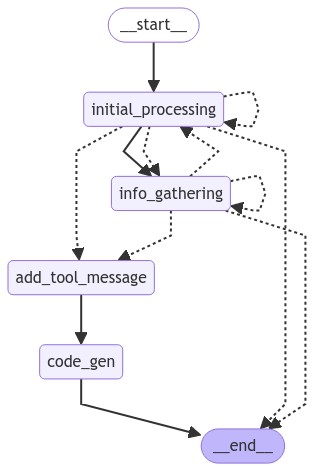

In [24]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import START, MessageGraph
from langchain_core.messages import ToolMessage

memory = SqliteSaver.from_conn_string(":memory:")
workflow = MessageGraph()

# Add nodes
workflow.add_node("initial_processing", get_initial_processing_messages | fast_llm)
workflow.add_node("info_gathering", info_gather_chain)
workflow.add_node("code_gen", code_gen_chain)

@workflow.add_node
def add_tool_message(state: list):
    return ToolMessage(
        content="Opentrons instructions received. Generating code...",
        tool_call_id=state[-1].tool_calls[0]["id"]
    )

# Add edge
workflow.add_edge(START, "initial_processing")
workflow.add_conditional_edges("initial_processing", get_state)
workflow.add_edge("initial_processing", "info_gathering")
workflow.add_conditional_edges("info_gathering", get_state)
workflow.add_edge("add_tool_message", "code_gen")
workflow.add_edge("code_gen", END)


# Compile the graph
graph = workflow.compile(checkpointer=memory)

# Visualization (if in a Jupyter environment)
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Use the graph

In [25]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    
    print(f"\n================================== Human Input ==================================\n{user}\n")
    
    messages = [HumanMessage(content=user)]
    output = None
    for output in graph.stream(messages, config=config, stream_mode="updates"):
        last_message = next(iter(output.values()))
        last_message.pretty_print()

    if output and "code_gen" in output:
        print("Done!")


================================== Human Input ==================================
Please set the temperature of the thermocycler in deck slot 7 to 90 degC. After it has reached that temp, please transfer 20 uL from well 1A of a 96 well plate in slot 1 to the plate on the thermocycler (same well). Blow out tip and then discard the tip.

================================== Ai Message ==================================

1. **Detailed Task Description**: The task involves programming an Opentrons liquid handling robot to perform a series of actions with a thermocycler and a 96-well plate. First, the robot will set the temperature of the thermocycler located in deck slot 7 to 90 degrees Celsius. Once the thermocycler has reached the specified temperature, the robot will transfer 20 microliters of liquid from well 1A of a 96-well plate positioned in deck slot 1 to the corresponding well (1A) of the plate inside the thermocycler. After the transfer is complete, the robot will blow out any rem